[Top-2 eigvec] Subspace alignment score: 0.2737
[Best-2 overlap] Subspace alignment score: 0.2737


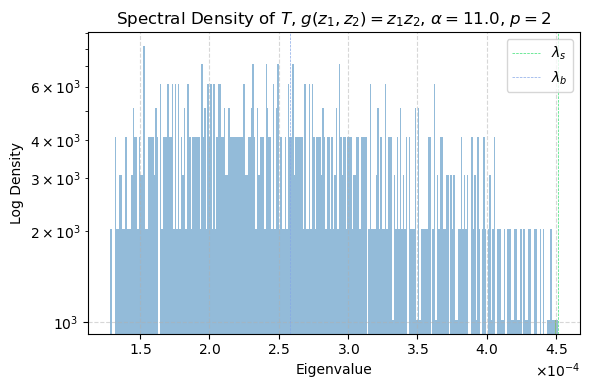

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import kv as besselk
from scipy.linalg import eigh
from matplotlib.ticker import ScalarFormatter


# Compute T(y) using Bessel-based expression
def compute_T_y_bessel(y_batch):
    abs_y = np.abs(y_batch)
    K1 = besselk(1, abs_y)
    K0 = besselk(0, abs_y)
    with np.errstate(divide='ignore', invalid='ignore'):
        lambda_y = abs_y * (K1 / K0)
        lambda_y[np.isnan(lambda_y)] = 0.0
        lambda_y[np.isinf(lambda_y)] = 0.0

    T_list = []
    for i in range(len(y_batch)):
        y_i = y_batch[i]
        lam = lambda_y[i]
        G = np.array([[lam, y_i],
                      [y_i, lam]])
        T_i = G @ np.linalg.inv(G + np.eye(2))
        T_list.append(T_i)
    return np.array(T_list)  # shape: (n, 2, 2)


# Construct the 2d × 2d spectral matrix T_hat
def build_T_hat(X, T_y):
    n, d = X.shape
    T_matrix = np.zeros((2 * d, 2 * d))
    for i in range(n):
        xi = X[i]
        Ti = T_y[i]
        A = np.outer(xi, xi)

        # Manually assemble the Kronecker-style blocks
        T_matrix[0:d, 0:d]     += Ti[0, 0] * A
        T_matrix[0:d, d:2*d]   += Ti[0, 1] * A
        T_matrix[d:2*d, 0:d]   += Ti[1, 0] * A
        T_matrix[d:2*d, d:2*d] += Ti[1, 1] * A
    T_matrix /= n
    return T_matrix


# Plot the spectral density with highlight and thresholds
def plot_spectrum(eigvals, alpha, p, signal_top=2, lambda_s=None, lambda_b=None, save_path=None):
    bulk_color = '#2878B5'
    signal_color = 'green'

    hist, bin_edges = np.histogram(eigvals, bins=300, density=True)
    bin_width = bin_edges[1] - bin_edges[0]
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    eigvals_sorted = np.sort(eigvals)
    signal_eigs = eigvals_sorted[-signal_top:]
    signal_bins = set(np.digitize(signal_eigs, bin_edges) - 1)

    plt.figure(figsize=(6, 4))
    for i in range(len(hist)):
        color = signal_color if i in signal_bins else bulk_color
        plt.bar(bin_centers[i], hist[i], width=bin_width, color=color, alpha=0.5)

    if lambda_s is not None:
        plt.axvline(lambda_s, color='#36E072', linestyle='--', linewidth=0.5, label=r'$\lambda_s$')
    if lambda_b is not None:
        plt.axvline(lambda_b, color='#85A7E7', linestyle='--', linewidth=0.5, label=r'$\lambda_b$')

    plt.yscale('log')
    plt.title(r"Spectral Density of $T$, $g(z_1,z_2) = z_1 z_2$, $\alpha = {:.1f}$, $p = {}$".format(alpha, p))
    plt.xlabel("Eigenvalue")
    plt.ylabel("Log Density")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend()

    ax = plt.gca()
    ax.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    ax.ticklabel_format(axis='x', style='sci', scilimits=(0, 0))
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
    plt.show()


# QR orthonormalization
def orthonormalize(A):
    Q, _ = np.linalg.qr(A)
    return Q


# Compute alignment score between estimated and true subspace
def compute_alignment(W_hat, W_star):
    Q1 = orthonormalize(W_hat)
    Q2 = orthonormalize(W_star)
    overlap = Q1.T @ Q2
    u, s, _ = np.linalg.svd(overlap)
    return np.mean(s)


def main():
    d = 456
    p = 2
    alpha = 11
    n = int(d * alpha)
    np.random.seed(42)

    # Generate true signal subspace and input data
    W_star = np.random.randn(d, p)
    W_star, _ = np.linalg.qr(W_star)
    X = np.random.randn(n, d) / np.sqrt(d)
    Z = X @ W_star
    z1, z2 = Z[:, 0], Z[:, 1]
    y = z1 * z2

    # Compute T(y) and construct T_hat
    T_y = compute_T_y_bessel(y)
    T_hat = build_T_hat(X, T_y)

    # Eigen-decomposition
    eigvals, eigvecs = eigh(T_hat)

    # Extract top-p eigenvectors (direct selection)
    top_vectors = eigvecs[:, -p:]
    W_hat = np.zeros((d, p))
    for j in range(p):
        W_hat[:, j] = top_vectors[j * d:(j + 1) * d, j]
    alignment_score = compute_alignment(W_hat, W_star)
    print(f"[Top-{p} eigvec] Subspace alignment score: {alignment_score:.4f}")

    # Greedy selection: top-p eigenvectors with highest overlaps
    overlaps = []
    for i in range(2 * d):
        vec = eigvecs[:, i]
        v1 = vec[:d]
        overlap_score = np.sum((W_star.T @ v1) ** 2)
        overlaps.append((i, overlap_score))
    overlaps.sort(key=lambda x: x[1], reverse=True)

    best_indices = [idx for idx, _ in overlaps[:p]]
    W_hat_best = np.zeros((d, p))
    for j, idx in enumerate(best_indices):
        W_hat_best[:, j] = eigvecs[:d, idx]
    improved_score = compute_alignment(W_hat_best, W_star)
    print(f"[Best-{p} overlap] Subspace alignment score: {improved_score:.4f}")

    # Plot spectrum
    lambda_s = eigvals[-1]
    lambda_b = eigvals[d - 1]
    plot_spectrum(eigvals, alpha=alpha, p=p, lambda_s=lambda_s, lambda_b=lambda_b)


if __name__ == "__main__":
    main()


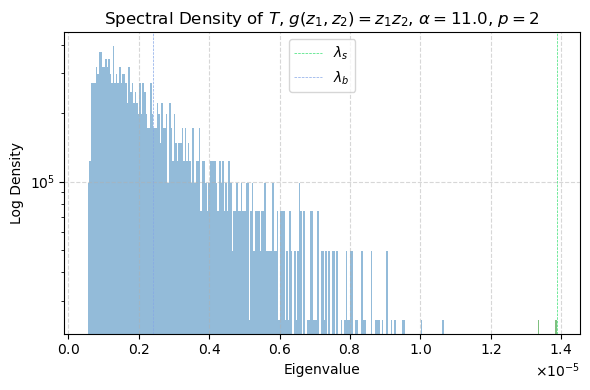

Subspace Alignment Score (normalized): 0.0107


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eigh
from matplotlib.ticker import ScalarFormatter


# Approximate the Bessel ratio with a rational function
def bessel_ratio_approx(y):
    abs_y = np.abs(y)
    a1, a2 = 0.5, 0.1
    b1, b2 = 0.4, 0.05
    num = 1 + a1 * abs_y + a2 * abs_y**2
    den = 1 + b1 * abs_y + b2 * abs_y**2
    return np.where(den > 1e-6, num / den, 0.0)


def compute_T_y_pade(y_batch):
    abs_y = np.abs(y_batch)
    ratio = bessel_ratio_approx(y_batch)
    lambda_y = abs_y * ratio

    T_list = []
    for i in range(len(y_batch)):
        y_i = y_batch[i]
        lam = lambda_y[i]
        G = np.array([[lam, y_i],
                      [y_i, lam]])
        T_i = G @ np.linalg.inv(G + np.eye(2))
        T_list.append(T_i)
    return np.array(T_list)  # shape: (n, 2, 2)


# Construct the 2d × 2d spectral matrix T_hat
def build_T_hat(X, T_y):
    n, d = X.shape
    T_matrix = np.zeros((2 * d, 2 * d))
    for i in range(n):
        xi = X[i]
        Ti = T_y[i]
        A = np.outer(xi, xi)

        # Manually assemble the Kronecker-style blocks
        T_matrix[0:d, 0:d]     += Ti[0, 0] * A
        T_matrix[0:d, d:2*d]   += Ti[0, 1] * A
        T_matrix[d:2*d, 0:d]   += Ti[1, 0] * A
        T_matrix[d:2*d, d:2*d] += Ti[1, 1] * A
    T_matrix /= n
    return T_matrix


# Plot the eigenvalue spectrum with highlighted signal components
def plot_spectrum_fixed(eigvals, alpha, p, signal_top=2, lambda_s=None, lambda_b=None, save_path=None):
    bulk_color = '#2878B5'
    signal_color = 'green'

    hist, bin_edges = np.histogram(eigvals, bins=300, density=True)
    bin_width = bin_edges[1] - bin_edges[0]
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    eigvals_sorted = np.sort(eigvals)
    signal_eigs = eigvals_sorted[-signal_top:]
    signal_bins = set([np.argmin(np.abs(bin_centers - eig)) for eig in signal_eigs])

    plt.figure(figsize=(6, 4))
    for i in range(len(hist)):
        color = signal_color if i in signal_bins else bulk_color
        plt.bar(bin_centers[i], hist[i], width=bin_width, color=color, alpha=0.5)

    if lambda_s is not None:
        plt.axvline(lambda_s, color='#36E072', linestyle='--', linewidth=0.5, label=r'$\lambda_s$')
    if lambda_b is not None:
        plt.axvline(lambda_b, color='#85A7E7', linestyle='--', linewidth=0.5, label=r'$\lambda_b$')

    plt.yscale('log')
    plt.title(r"Spectral Density of $T$, $g(z_1,z_2) = z_1 z_2$, $\alpha = {:.1f}$, $p = {}$".format(alpha, p))
    plt.xlabel("Eigenvalue")
    plt.ylabel("Log Density")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend()

    ax = plt.gca()
    ax.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    ax.ticklabel_format(axis='x', style='sci', scilimits=(0, 0))

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
    plt.show()


# Compute subspace alignment between estimated and true subspaces
def compute_alignment_score(eigvecs, W_star, d, p):
    W_hat_list = []
    for i in range(p):
        v = eigvecs[:, -1 - i]  # Select the top-p eigenvectors
        mat = v.reshape(d, p)
        u, _, _ = np.linalg.svd(mat, full_matrices=False)
        W_hat_list.append(u[:, 0])  # Use the dominant left singular vector
    W_hat = np.stack(W_hat_list, axis=1)

    score = np.linalg.norm(W_hat.T @ W_star, ord='fro')**2 / p
    return score


def main():
    d = 456
    p = 2
    alpha = 11
    n = int(d * alpha)
    np.random.seed(42)

    # Generate signal directions
    W_star = np.random.randn(d, p)
    W_star, _ = np.linalg.qr(W_star)

    # Generate input and responses
    X = np.random.randn(n, d) / np.sqrt(d)
    Z = X @ W_star
    z1, z2 = Z[:, 0], Z[:, 1]
    y = z1 * z2  # Link function

    # Compute T(y) using Pade-based approximation
    T_y = compute_T_y_pade(y)

    # Construct the spectral estimator matrix
    T_hat = build_T_hat(X, T_y)

    # Compute eigenvalues and eigenvectors
    eigvals, eigvecs = eigh(T_hat, eigvals_only=False)

    # Identify spectral thresholds and plot spectrum
    lambda_s = eigvals[-1]      # Largest eigenvalue (signal)
    lambda_b = eigvals[d - 1]   # d-th eigenvalue (bulk edge)

    plot_spectrum_fixed(eigvals=eigvals,
                        alpha=alpha,
                        p=p,
                        signal_top=2,
                        lambda_s=lambda_s,
                        lambda_b=lambda_b)

    # Recompute spectrum (optional)
    eigvals, eigvecs = eigh(T_hat, eigvals_only=False)

    # Compute subspace recovery score
    score = compute_alignment_score(eigvecs, W_star, d, p)
    print(f"Subspace Alignment Score (normalized): {score:.4f}")


if __name__ == "__main__":
    main()
